# Simulate from FEM

## Imports


:::{.callout-warning}
You need to modify  `ZOOMY_AMREX_HOME` below to point to your local AMReX installation
:::

In [1]:
import os
from pathlib import Path
import sys
import rasterio
os.environ['PYTHONPATH'] = os.path.join(os.getcwd(), '../../..')
os.environ['ZOOMY_DIR'] = os.path.join(os.getcwd(), '../../..')
os.environ['ZoomyLog'] = 'Default'
os.environ['ZoomyLogLevel'] = 'INFO'
os.environ['JAX_ENABLE_X64'] = 'True'
os.environ['ZOOMY_AMREX_HOME'] = '/home/is086873/MBD/Git/amrex'


project_root = Path.cwd().parents[2]  # 0=current, 1=.., 2=../..
sys.path.append(str(project_root))

In [2]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
from sympy import Matrix

from library.fvm.solver import Settings
from library.model.models.shallow_water import ShallowWaterEquations
from library.model.models.shallow_moments_topo import ShallowMomentsTopo, ShallowMomentsTopoNumerical


import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
from library.misc.misc import Zstruct
import library.transformation.to_c as trafo
from tutorials.amrex.helper import create_artificial_raster, show_raster

2025-09-03 06:19:32.616 | WARNING  | library.fvm.solver:<module>:28 - No module named 'precice'


## Model definition

In [3]:
# Currently, BCs are not implemented in AMReX and periodic BCs are applied
bcs = BC.BoundaryConditions(
    [
        BC.Extrapolation(physical_tag="N"),
        BC.Extrapolation(physical_tag="S"),
        BC.Extrapolation(physical_tag="E"),
        BC.Extrapolation(physical_tag="W"),
    ]
)


class MyModel(ShallowMomentsTopoNumerical):
    def source(self):
        out = Matrix([0 for i in range(self.n_variables)])
        out += self.inclination()
        out += self.newtonian()
        out += self.slip_mod()
        out += self.chezy()
        return self.substitute_precomputed_denominator(out, self.variables[1], self.aux_variables.hinv)
         

level = 0
model = MyModel(
    level=level,
    boundary_conditions=bcs,
    parameters=Zstruct(nu=0.000001, lamda=1/1000., rho=1000, c_slipmod=1/30, C=1/6),
    # aux_variables = ['hinv'] + [f'dalpha_{i}_dx' for i in range(level+1)] + [f'dbeta_{i}_dy' for i in range(level+1)],
    aux_variables = ['hinv'],
    
)


In [4]:
print(model.parameters.keys())
print(model.parameter_values)

['g', 'ex', 'ey', 'ez', 'rho', 'nu', 'lamda', 'c_slipmod', 'C']
[9.81000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+03 1.00000000e-06 1.00000000e-03 3.33333333e-02
 1.66666667e-01]


In [5]:
model.source()

⎡                       0                        ⎤
⎢                                                ⎥
⎢                       0                        ⎥
⎢                                                ⎥
⎢                         _______________________⎥
⎢                        ╱     2   2       2   2 ⎥
⎢          1.0⋅hinv⋅q₂⋅╲╱  hinv ⋅q₂  + hinv ⋅q₃  ⎥
⎢ex⋅g⋅q₁ - ──────────────────────────────────────⎥
⎢                             2                  ⎥
⎢                            C                   ⎥
⎢                                                ⎥
⎢                         _______________________⎥
⎢                        ╱     2   2       2   2 ⎥
⎢          1.0⋅hinv⋅q₃⋅╲╱  hinv ⋅q₂  + hinv ⋅q₃  ⎥
⎢ey⋅g⋅q₁ - ──────────────────────────────────────⎥
⎢                             2                  ⎥
⎣                            C                   ⎦

In [6]:
model.eigenvalues()

⎡                            0                             ⎤
⎢                                                          ⎥
⎢                   hinv⋅(n₀⋅q₂ + n₁⋅q₃)                   ⎥
⎢                                                          ⎥
⎢      ⎛                         __________    ___________⎞⎥
⎢    2 ⎜                        ╱        5    ╱   2     2 ⎟⎥
⎢hinv ⋅⎝n₀⋅q₁⋅q₂ + n₁⋅q₁⋅q₃ + ╲╱  ez⋅g⋅q₁  ⋅╲╱  n₀  + n₁  ⎠⎥
⎢                                                          ⎥
⎢      ⎛                         __________    ___________⎞⎥
⎢    2 ⎜                        ╱        5    ╱   2     2 ⎟⎥
⎣hinv ⋅⎝n₀⋅q₁⋅q₂ + n₁⋅q₁⋅q₃ - ╲╱  ez⋅g⋅q₁  ⋅╲╱  n₀  + n₁  ⎠⎦

In [7]:
model.quasilinear_matrix()

⎡⎡   0              0               0         0   ⎤  ⎡   0              0      ↪
⎢⎢                                                ⎥  ⎢                         ↪
⎢⎢   0              0               1         0   ⎥  ⎢   0              0      ↪
⎢⎢                                                ⎥  ⎢                         ↪
⎢⎢                       2   2                    ⎥, ⎢                 2       ↪
⎢⎢ez⋅g⋅q₁  ez⋅g⋅q₁ - hinv ⋅q₂   2⋅hinv⋅q₂     0   ⎥  ⎢   0        -hinv ⋅q₂⋅q₃ ↪
⎢⎢                                                ⎥  ⎢                         ↪
⎢⎢                 2                              ⎥  ⎢                       2 ↪
⎣⎣   0        -hinv ⋅q₂⋅q₃       hinv⋅q₃   hinv⋅q₂⎦  ⎣ez⋅g⋅q₁  ez⋅g⋅q₁ - hinv  ↪

↪          0         0    ⎤⎤
↪                         ⎥⎥
↪          0         1    ⎥⎥
↪                         ⎥⎥
↪                         ⎥⎥
↪       hinv⋅q₃   hinv⋅q₂ ⎥⎥
↪                         ⎥⎥
↪    2                    ⎥⎥
↪ ⋅q₃      0     2⋅hinv⋅q₃⎦⎦

## Display DEM inputs

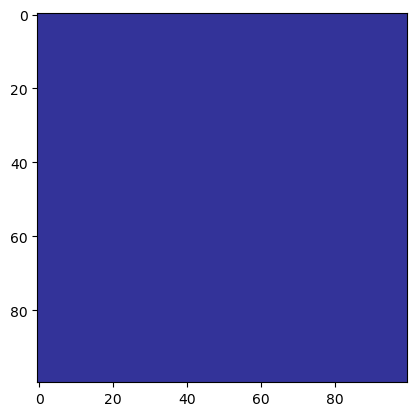

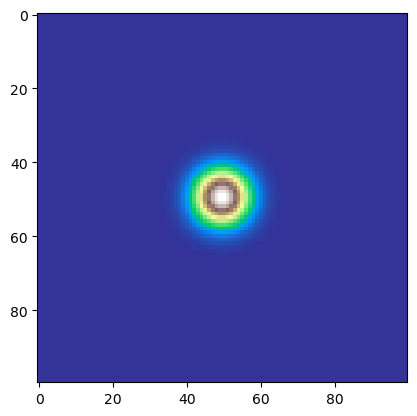

In [8]:
main_dir = os.getenv("ZOOMY_DIR")
dem_path = os.path.join(main_dir, 'data/ca_elev.tif')
ic_water_path = os.path.join(main_dir, 'data/ca_debrisflow.tif')

dem_path = os.path.join(main_dir, 'data/evel_artificial.tif')
ic_water_path = os.path.join(main_dir, 'data/release_artificial.tif')
N = 50
dx = 1
M = N * dx
create_artificial_raster(lambda x, y: 1*np.exp((-x**2-y**2)/M)+1., (-M, M, -M, M), dx, ic_water_path)
create_artificial_raster(lambda x, y: 0. * np.exp(-(x+M)**2/M**2), (-M, M, -M, M), dx, dem_path)

show_raster(dem_path)
show_raster(ic_water_path)


## Code transformation and AMReX compilation

currently, we always "clean" and compile from scratch. Comment out "make clean" to disable.

In [9]:

import shutil
from pathlib import Path
settings = Settings(name="ShallowWater", output=Zstruct(directory="outputs/amrex"))
source_dir = Path(os.path.join(main_dir, 'library/amrex/Exec'))
output_dir = Path(os.path.join(main_dir, settings.output.directory))

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

trafo.to_c(model, settings)
main_dir = os.getenv("ZOOMY_DIR")
os.environ['ZOOMY_AMREX_MODEL'] = os.path.join(main_dir, os.path.join(settings.output.directory, '.c_interface'))

2025-09-03 06:19:36.190 | WARNING  | library.misc.misc:__init__:143 - No 'filename' attribute found in output Zstruct. Default: 'simulation'
2025-09-03 06:19:36.191 | WARNING  | library.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


In [10]:
import subprocess

base = os.path.join(os.environ['ZOOMY_DIR'], 'library/amrex/')
cmds = [
    f"cp ../../{settings.output.directory}/.c_interface/model.h ./Source/model.h",
    "source ~/.zshrc",
    "source setup.sh",
    "cd Exec",
    # "make clean",
    "make"
]

subprocess.run(" && ".join(cmds), shell=True, executable="/bin/zsh", cwd=base)



[WARN] OpenMPI's default binding is set to OFF, you can override this
[INFO] Module foss/2024a loaded.
fatal: not a git repository (or any parent up to mount point /rwthfs/rz/cluster/home)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


Loading /home/is086873/MBD/Git/amrex/Tools/GNUMake/comps/gnu.mak...
Loading /home/is086873/MBD/Git/amrex/Tools/GNUMake/sites/Make.unknown...
Compiling write_plotfiles.cpp ...
mpicxx -MMD -MP -Werror=return-type -gdwarf-4 -O3 -finline-limit=43210 -std=c++17  -pthread    -DBL_USE_MPI -DAMREX_USE_MPI -DAMREX_GPU_MAX_THREADS=0 -DBL_SPACEDIM=3 -DAMREX_SPACEDIM=3 -DBL_FORT_USE_UNDERSCORE -DAMREX_FORT_USE_UNDERSCORE -DBL_Linux -DAMREX_Linux -DNDEBUG -DOMPI_SKIP_MPICXX -Itmp_build_dir/s/3d.gnu.MPI.EXE -I. -I../Source -I/rwthfs/rz/cluster/home/is086873/Git/Zoomy/web/tutorials/amrex/../../../outputs/amrex/.c_interface -I/home/is086873/MBD/Git/amrex/Src/Base -I/home/is086873/MBD/Git/amrex/Src/Base/Parser  -I/cvmfs/software.hpc.rwth.de/Linux/RH9/x86_64/intel/sapphirerapids/software/OpenMPI/5.0.3-GCC-13.3.0/include -c ../Source/write_plotfiles.cpp -o tmp_build_dir/o/3d.gnu.MPI.EXE/write_plotfiles.o
Compiling main.cpp ...
mpicxx -MMD -MP -Werror=return-type -gdwarf-4 -O3 -finline-limit=43210 -std=c+

CompletedProcess(args='cp ../../outputs/amrex/.c_interface/model.h ./Source/model.h && source ~/.zshrc && source setup.sh && cd Exec && make', returncode=0)

## Prepare raster data for AMReX

... and copy stuff to the output directory ...

In [11]:


output_dir.mkdir(parents=True, exist_ok=True)  # make sure output folder exists

for item in source_dir.iterdir():
    dest = output_dir / item.name
    if item.is_dir():
        shutil.copytree(item, dest, dirs_exist_ok=True)
    else:
        shutil.copy2(item, dest)
        
shutil.copy(dem_path, output_dir)
shutil.copy(ic_water_path, output_dir)

print("The simulation output will be written to: ", output_dir)

from library.amrex.preprocess_rasterdata import preprocess
preprocess(os.path.join(output_dir, 'inputs'), dem_path, ic_water_path)


The simulation output will be written to:  /rwthfs/rz/cluster/home/is086873/Git/Zoomy/web/tutorials/amrex/../../../outputs/amrex
✓ raw files: evel_artificial.raw release_artificial.raw
✓ inputs updated → /rwthfs/rz/cluster/home/is086873/Git/Zoomy/outputs/amrex/inputs


## Do the Simulation

run in the notebook or as a batch job

In [12]:
run_in_notebook = True

In [ ]:
if (run_in_notebook):
    base = os.path.join(os.environ['ZOOMY_DIR'], 'library/amrex/')
    cmds = [
        "source ~/.zshrc",
        "source setup.sh",
        f"cd ../../{settings.output.directory}",
        "./clean.sh",
        "mpiexec -np 4 ./main3d.gnu.MPI.ex inputs",
    ]

    subprocess.run("\n".join(cmds), shell=True, executable="/bin/zsh", cwd=base)
else:
    
    base = os.path.join(os.environ['ZOOMY_DIR'], 'library/amrex/')
    cmds = [
        "source ~/.zshrc",
        "source setup.sh",
        f"cd ../../{settings.output.directory}",
        "./clean.sh",
        "sbatch batch.sh < inputs",
    ]

    subprocess.run("\n".join(cmds), shell=True, executable="/bin/zsh", cwd=base)

        

[WARN] OpenMPI's default binding is set to OFF, you can override this
[INFO] Module foss/2024a loaded.
./clean.sh:3: no matches found: plt*
./clean.sh:4: no matches found: output*.txt
./clean.sh:5: no matches found: Backtrace*


Initializing AMReX (25.03)...
MPI initialized with 4 MPI processes
MPI initialized with thread support level 0
AMReX (25.03) initialized
dem_file = '/rwthfs/rz/cluster/home/is086873/Git/Zoomy/data/evel_artificial.raw'
release_file = '/rwthfs/rz/cluster/home/is086873/Git/Zoomy/data/release_artificial.raw'
✓ loaded '/rwthfs/rz/cluster/home/is086873/Git/Zoomy/data/release_artificial.raw' into component 1 (100×100)
✓ loaded '/rwthfs/rz/cluster/home/is086873/Git/Zoomy/data/evel_artificial.raw' into component 0 (100×100)
  Evolve: abs_max_ev: 4.418414752 dt: 1e-07
Advance: Time: 0 s,  0 << iteration  in 2.722686402 seconds; 
  Evolve: abs_max_ev: 4.407627717 dt: 1e-07
Advance: Time: 1e-07 s,  1 << iteration  in 0.00151619 seconds; 
  Evolve: abs_max_ev: 4.397024386 dt: 1e-07
Advance: Time: 2e-07 s,  2 << iteration  in 0.001418618 seconds; 
  Evolve: abs_max_ev: 4.386600021 dt: 1e-07
Advance: Time: 3e-07 s,  3 << iteration  in 0.001411615 seconds; 
  Evolve: abs_max_ev: 4.376350046 dt: 1e-07
